In [1]:
import pandas as pd
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
import itertools
from sklearn.preprocessing import StandardScaler
from joblib import Parallel, delayed

In [2]:
df=pd.read_csv('input/processed/28/28_datos_procesados.csv')

In [3]:
df.columns

Index(['Fecha_Hora', 'pm25', 'no', 'no2', 'nox', 'dviento_ssr', 'haire10_ssr',
       'p_ssr', 'rglobal_ssr', 'taire10_ssr',
       ...
       'taire10_ssr_lag48', 'vviento_ssr_lag1', 'vviento_ssr_lag2',
       'vviento_ssr_lag3', 'vviento_ssr_lag4', 'vviento_ssr_lag5',
       'vviento_ssr_lag6', 'vviento_ssr_lag12', 'vviento_ssr_lag24',
       'vviento_ssr_lag48'],
      dtype='object', length=101)

In [4]:
df.columns[:20]

Index(['Fecha_Hora', 'pm25', 'no', 'no2', 'nox', 'dviento_ssr', 'haire10_ssr',
       'p_ssr', 'rglobal_ssr', 'taire10_ssr', 'vviento_ssr', 'pm25_lag1',
       'pm25_lag2', 'pm25_lag3', 'pm25_lag4', 'pm25_lag5', 'pm25_lag6',
       'pm25_lag12', 'pm25_lag24', 'pm25_lag48'],
      dtype='object')

In [5]:
# If there is a datetime column, parse it and set as index
if 'Fecha_Hora' in df.columns:
    df['Fecha_Hora'] = pd.to_datetime(df['Fecha_Hora'])
    df = df.sort_values('Fecha_Hora')
    df = df.set_index('Fecha_Hora')
elif 'fecha_hora' in df.columns:
    df['fecha_hora'] = pd.to_datetime(df['fecha_hora'])
    df = df.sort_values('fecha_hora')
    df = df.set_index('fecha_hora')
else:
    # Fallback: ensure data is ordered as in the file
    df = df.sort_index()

# Drop any remaining NaNs (SARIMAX cannot handle them directly)
df = df.dropna()
# df = df.iloc[-10000:].copy()  # Use last 10k samples for fitting while prototyping

target_col = 'pm25'
y = df[target_col]
exog_cols = [col for col in df.columns if col != target_col and not col.startswith(f"{target_col}_lag")]
X = df[exog_cols]

split_idx = int(len(df) * 0.8)
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]
X_train_raw, X_test_raw = X.iloc[:split_idx], X.iloc[split_idx:]

In [6]:
scaler = StandardScaler()
X_train = pd.DataFrame(
    scaler.fit_transform(X_train_raw),
    index=X_train_raw.index,
    columns=X_train_raw.columns,
)
X_test = pd.DataFrame(
    scaler.transform(X_test_raw),
    index=X_test_raw.index,
    columns=X_test_raw.columns,
)

# Verificación de variables numéricas

## Variable objetivo

<Axes: >

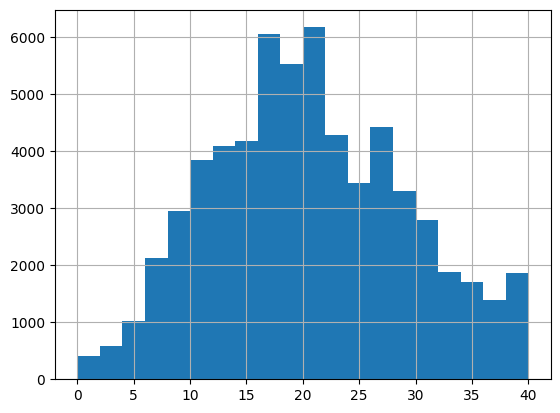

In [7]:
df['pm25'].hist(bins=20)

## Otros contaminantes

In [8]:
df['no'].describe()

count    62064.000000
mean        15.757061
std         16.882034
min          0.000000
25%          3.775425
50%          9.629580
75%         22.163275
max        119.885000
Name: no, dtype: float64

<Axes: >

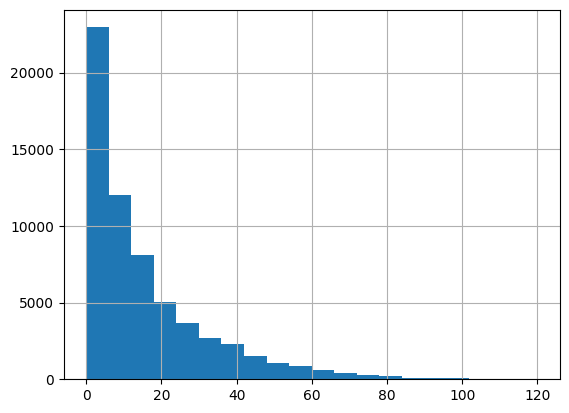

In [9]:
df['no'].hist(bins=20)

<Axes: >

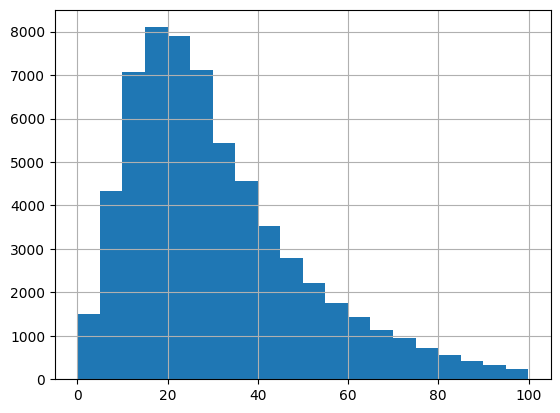

In [10]:
df['nox'].hist(bins=20)

# SARIMAX

In [11]:
# Candidate orders based on your EDA
p = [1, 2]
d = [0, 1]
q = [0, 1]
P = [0, 1]
D = [1]          # enforce seasonal differencing
Q = [0, 1]
s = 24

orders = list(itertools.product(p, d, q))
seasonals = list(itertools.product(P, D, Q))

def fit_sarimax(order, seasonal, y_train, X_train):
    seasonal_order = (*seasonal, s)
    try:
        model = sm.tsa.SARIMAX(
            endog=y_train,
            exog=X_train,
            order=order,
            seasonal_order=seasonal_order,
            enforce_stationarity=False,
            enforce_invertibility=False,
        )
        res = model.fit(disp=False, maxiter=300)
        print(f"Fitted order={order}, seasonal={seasonal_order}, AIC={res.aic:.1f}, BIC={res.bic:.1f}")
        return {
            "order": order,
            "seasonal_order": seasonal_order,
            "aic": res.aic,
            "bic": res.bic,
        }
    except Exception as e:
        print(f"Failed order={order}, seasonal={seasonal_order}: {e}")
        return None

# --- PARALLEL GRID SEARCH ---
results = Parallel(n_jobs=-1, verbose=5)(
    delayed(fit_sarimax)(order, seasonal, y_train, X_train)
    for order in orders
    for seasonal in seasonals
)

# Remove failed fits
results = [r for r in results if r is not None]

# Sort by AIC
results_sorted = sorted(results, key=lambda x: x["aic"])
results_sorted[:10]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


/home/manuel/Documents/Maestria_Analitica/Semestre_II/AQI_Predict/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/home/manuel/Documents/Maestria_Analitica/Semestre_II/AQI_Predict/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/home/manuel/Documents/Maestria_Analitica/Semestre_II/AQI_Predict/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/home/manuel/Documents/Maestria_Analitica/Semestre_II/AQI_Predict/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred freque

Fitted order=(1, 0, 0), seasonal=(0, 1, 0, 24), AIC=345814.8, BIC=346625.5


/home/manuel/Documents/Maestria_Analitica/Semestre_II/AQI_Predict/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/home/manuel/Documents/Maestria_Analitica/Semestre_II/AQI_Predict/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


Fitted order=(1, 1, 0), seasonal=(0, 1, 0, 24), AIC=355569.4, BIC=356380.1


/home/manuel/Documents/Maestria_Analitica/Semestre_II/AQI_Predict/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/home/manuel/Documents/Maestria_Analitica/Semestre_II/AQI_Predict/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/home/manuel/Documents/Maestria_Analitica/Semestre_II/AQI_Predict/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fitted order=(1, 0, 1), seasonal=(0, 1, 0, 24), AIC=344757.8, BIC=345577.4


/home/manuel/Documents/Maestria_Analitica/Semestre_II/AQI_Predict/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/home/manuel/Documents/Maestria_Analitica/Semestre_II/AQI_Predict/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


Fitted order=(1, 1, 1), seasonal=(0, 1, 0, 24), AIC=345841.3, BIC=346660.9


/home/manuel/Documents/Maestria_Analitica/Semestre_II/AQI_Predict/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/home/manuel/Documents/Maestria_Analitica/Semestre_II/AQI_Predict/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


KeyboardInterrupt: 

# Evaluación

MSE: 52.961
RMSE: 7.277
R2: 0.091


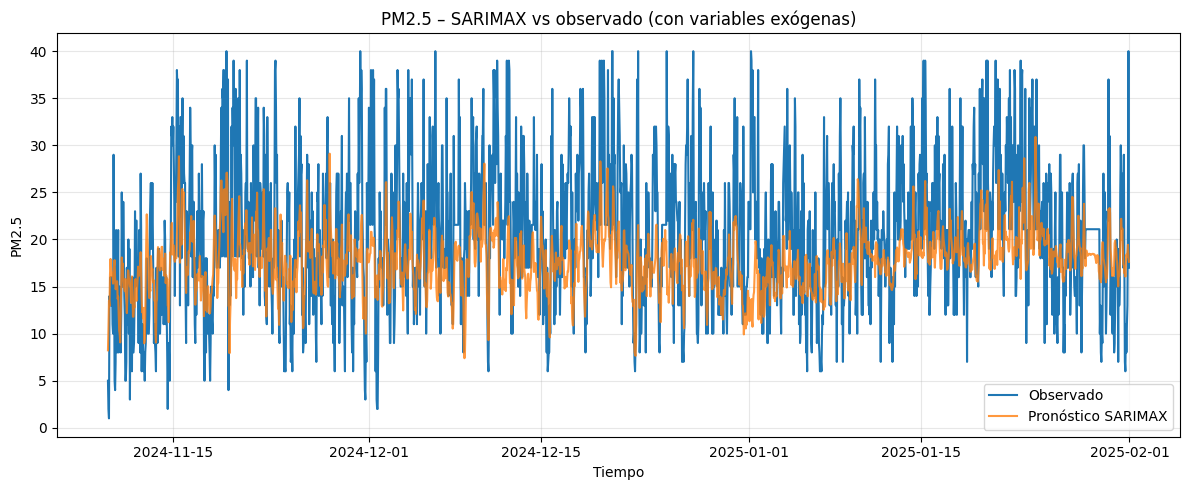

In [ ]:
best_order = results_sorted[0]["order"]
best_seasonal_order = results_sorted[0]["seasonal_order"]

sarimax_model = sm.tsa.SARIMAX(
    endog=y_train,
    exog=X_train,
    order=best_order,
    seasonal_order=best_seasonal_order,
    enforce_stationarity=False,
    enforce_invertibility=False,
)

sarimax_res = sarimax_model.fit(disp=True)

# Dynamic forecast over the test period
y_pred_test = sarimax_res.predict(
    start=y_test.index[0],
    end=y_test.index[-1],
    exog=X_test
)

# Align indices
y_pred_test = y_pred_test.loc[y_test.index]

mse = mean_squared_error(y_test, y_pred_test)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred_test)
print(f"MSE: {mse:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"R2: {r2:.3f}")

# Plot true vs predicted
plt.figure(figsize=(12, 5))
plt.plot(y_test.index, y_test, label='Observado')
plt.plot(y_test.index, y_pred_test, label='Pronóstico SARIMAX', alpha=0.8)
plt.legend()
plt.title('PM2.5 – SARIMAX vs observado (con variables exógenas)')
plt.xlabel('Tiempo')
plt.ylabel('PM2.5')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
# Import ACF and PACF plotting functions
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf-

resid = sarimax_res.resid

fig, ax = plt.subplots(2, 1, figsize=(10, 6))
plot_acf(resid, lags=60, ax=ax[0])
ax[0].set_title("ACF of residuals")
plot_pacf(resid, lags=60, ax=ax[1])
ax[1].set_title("PACF of residuals")
plt.tight_layout()
plt.show()

In [15]:
# Univariate baseline: only pm25
y_uni = y_train
y_uni_test = y_test

arima_model = sm.tsa.SARIMAX(
    endog=y_uni,
    order=(1, 0, 1),
    seasonal_order=(0, 0, 0, 0),
    enforce_stationarity=False,
    enforce_invertibility=False,
)
arima_res = arima_model.fit(disp=True)

# Forecast test period
y_uni_pred = arima_res.predict(start=y_uni_test.index[0], end=y_uni_test.index[-1])

mse_uni = mean_squared_error(y_uni_test, y_uni_pred)
rmse_uni = np.sqrt(mse_uni)
r2_uni = r2_score(y_uni_test, y_uni_pred)
print(f"[UNIVARIATE] RMSE: {rmse_uni:.3f}  R2: {r2_uni:.3f}")

/home/manuel/Documents/Maestria_Analitica/Semestre_II/AQI_Predict/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/home/manuel/Documents/Maestria_Analitica/Semestre_II/AQI_Predict/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


[UNIVARIATE] RMSE: 21.290  R2: -5.071


In [16]:
y_train.describe(), y_test.describe()

(count    49651.000000
 mean        20.308903
 std          8.698751
 min          0.000000
 25%         14.000000
 50%         20.000000
 75%         27.000000
 max         40.000000
 Name: pm25, dtype: float64,
 count    12413.000000
 mean        19.497626
 std          8.640923
 min          0.000000
 25%         13.000000
 50%         19.000000
 75%         25.000000
 max         40.000000
 Name: pm25, dtype: float64)

In [13]:
# ...existing code...

# Persistence baseline: ŷ_t = y_{t-1}
y_naive = y_test.shift(1)
y_naive = y_naive.dropna()
y_test_aligned = y_test.loc[y_naive.index]

rmse_naive = np.sqrt(mean_squared_error(y_test_aligned, y_naive))
r2_naive = r2_score(y_test_aligned, y_naive)
print(f"[NAIVE] RMSE: {rmse_naive:.3f}  R2: {r2_naive:.3f}")

[NAIVE] RMSE: 7.618  R2: 0.223
